In [1]:
import pandas as pd
import numpy as np
from matplotlib import  pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots

In [2]:
data = pd.read_csv("/Users/armaan/Desktop/imc-prosperity-quant-nyc/data_bottles/round-3-island-data-bottle/prices_round_3_day_0.csv", sep=";")
data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,999800,GIFT_BASKET,71131,19,71130.0,21.0,NaN,NaN,71145,19,71146.0,21.0,NaN,NaN,71138.0,0.0
39996,0,999900,CHOCOLATE,7987,124,NaN,NaN,NaN,NaN,7989,124,NaN,NaN,NaN,NaN,7988.0,0.0
39997,0,999900,GIFT_BASKET,71117,2,71116.0,16.0,71115.0,18.0,71128,2,71130.0,16.0,71131.0,18.0,71122.5,0.0
39998,0,999900,ROSES,14550,18,14549.0,46.0,NaN,NaN,14551,64,NaN,NaN,NaN,NaN,14550.5,0.0


In [3]:
chocolateDf = data[data['product'] == "CHOCOLATE"]
chocolateDf = chocolateDf.set_index('timestamp')
gift_basketDf = data[data['product'] == "GIFT_BASKET"]
gift_basketDf = gift_basketDf.set_index('timestamp')
rosesDf = data[data['product'] == "ROSES"]
rosesDf = rosesDf.set_index('timestamp')
strawberriesDf = data[data['product'] == "STRAWBERRIES"]

strawberriesDf = strawberriesDf.set_index('timestamp')

In [4]:
chocolate_mid_price = chocolateDf['mid_price']
roses_mid_price = rosesDf['mid_price']
strawberries_mid_price = strawberriesDf['mid_price']
gift_basket_mid_price = gift_basketDf['mid_price']

roses_mid_price

timestamp
0         15000.0
100       15000.0
200       15000.5
300       15000.0
400       14997.5
           ...   
999500    14543.5
999600    14548.0
999700    14546.5
999800    14546.5
999900    14550.5
Name: mid_price, Length: 10000, dtype: float64

In [5]:
mid_price_df = pd.concat([chocolate_mid_price,roses_mid_price,strawberries_mid_price,gift_basket_mid_price],axis =1)
mid_price_df.columns = ['chocolate', 'rose','strawberry','gift_basket'] 
mid_price_df.insert(0,"intercept",1)
mid_price_df

,intercept,chocolate,rose,strawberry,gift_basket
timestamp,,,,,
0,1,8000.0,15000.0,4000.0,71355.0
100,1,8001.5,15000.0,3999.5,71349.5
200,1,8001.0,15000.5,3999.5,71347.0
300,1,8002.5,15000.0,3999.5,71350.5
400,1,8002.0,14997.5,3999.5,71341.5
...,...,...,...,...,...
999500,1,7987.5,14543.5,4031.0,71141.5
999600,1,7988.5,14548.0,4031.0,71134.5
999700,1,7987.5,14546.5,4031.0,71128.5


In [6]:
mid_price_df = mid_price_df.reset_index()

In [7]:
def quantile_normalize(series):
    sorted_series = series.sort_values()
    norm = np.random.normal(
        loc=0, scale=1, size=len(series)
    )  # generate a normal distribution
    norm.sort()
    quantile_norm = series.copy().sort_values().reset_index(drop=True)
    quantile_norm.loc[sorted_series.index] = (
        norm  # assign normal values based on the rank
    )
    return quantile_norm

In [8]:
nav = 4 * mid_price_df['chocolate'] + 6 *mid_price_df['strawberry'] + mid_price_df['rose']
spread_basket = mid_price_df['gift_basket'] - nav
mid_price_df['spread'] = spread_basket

mid_price_df['chocolate_z_score'] = quantile_normalize(mid_price_df['chocolate'])
mid_price_df['rose_z_score'] = quantile_normalize(mid_price_df['rose'])


N = 4  # Number of lags
for i in range(1, N + 1):
    mid_price_df[f'chocolate_lag_{i}'] = mid_price_df['chocolate_z_score'].shift(i)
    mid_price_df[f'rose_lag_{i}'] = mid_price_df['rose_z_score'].shift(i)

mid_price_df = mid_price_df.dropna()

feature_columns = [col for col in mid_price_df.columns if 'lag' in col]
X = mid_price_df[feature_columns]

y = mid_price_df['strawberry']
y = y.to_numpy()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X, y)

# Model Evaluation
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 218.23363556093838


In [9]:
mid_price_df['residuals'] = y - predictions

In [11]:
mid_price_df = mid_price_df.reset_index()
mid_price_df['residuals_qnorm'] = quantile_normalize(mid_price_df['residuals'])

In [12]:
df = mid_price_df
df["residuals_qnormzscore"] = (
    df["residuals_qnorm"]
    - df["residuals_qnorm"].expanding().mean()
) / df["residuals_qnorm"].expanding().std(ddof=1)

In [13]:
Z_SCORE_THRESH = 2.3
# Create a Pandas DataFrame to display the results
overbought = df[df['residuals_qnormzscore'] > Z_SCORE_THRESH]
oversold = df[df['residuals_qnormzscore'] < -Z_SCORE_THRESH]

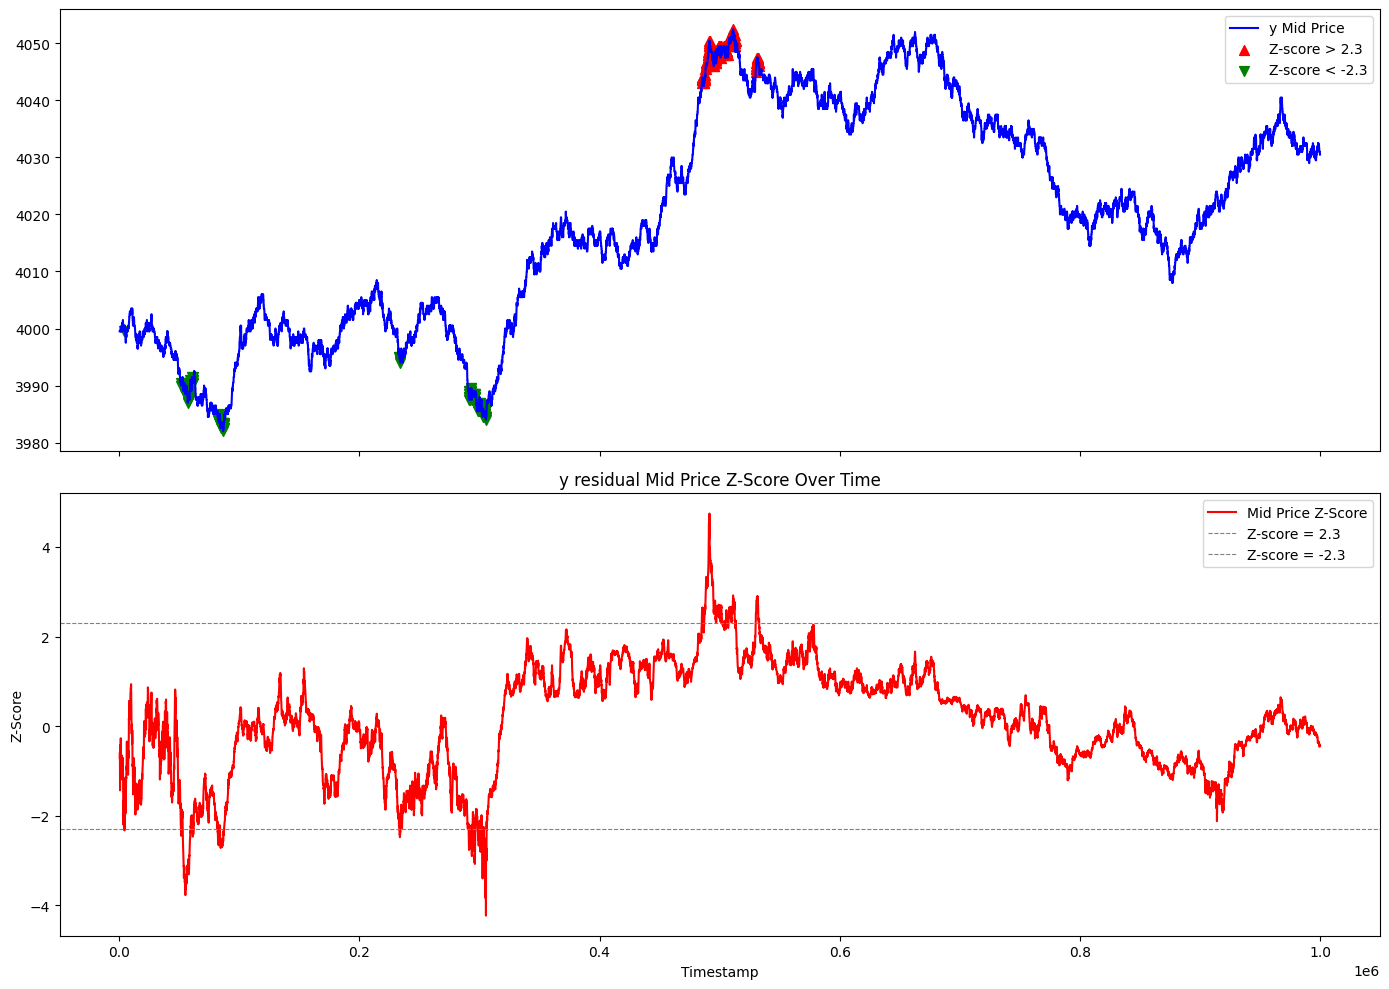

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
product = "strawberry"
ax[0].plot(
    df['timestamp'],
    df[product],
    label="y Mid Price",
    color="blue",
)
ax[0].scatter(
    overbought['timestamp'],
    overbought[product],
    color="red",
    label=f"Z-score > {Z_SCORE_THRESH}",
    marker="^",
    s=50,
)

ax[0].scatter(
    oversold['timestamp'],
    oversold[product],
    color="green",
    label=f"Z-score < -{Z_SCORE_THRESH}",
    marker="v",
    s=50,
)

# Plotting the gift basket mid price Z-score
ax[1].plot(
    df['timestamp'],
    df['residuals_qnormzscore'],
    label="Mid Price Z-Score",
    color="red",
)
ax[1].set_title("y residual Mid Price Z-Score Over Time")
ax[1].set_ylabel("Z-Score")
ax[1].set_xlabel("Timestamp")

ax[1].axhline(
    y=Z_SCORE_THRESH,
    color="gray",
    linestyle="--",
    linewidth=0.8,
    label=f"Z-score = {Z_SCORE_THRESH}",
)
ax[1].axhline(
    y=-Z_SCORE_THRESH,
    color="gray",
    linestyle="--",
    linewidth=0.8,
    label=f"Z-score = -{Z_SCORE_THRESH}",
)

# Show legend
ax[0].legend()
ax[1].legend()

# Improve layout
plt.tight_layout()
plt.show()